# 视频检测 V2

使用说明：

我储存了all_information，其中embedding是128。所有的检测都在一个function中。

In [1]:
#基本的引入，按字母表排序
import cv2
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from numpy import random
from numpy.random import uniform
import os
import PIL
from PIL import Image, ImageDraw
import random
from random import shuffle
import sys
sys.path.append(r'py')
import time
from tqdm import tqdm
#torch部分的import
import torch
import torchvision.transforms as transforms

# 读取视频

## 实时读取视频（摄像头）

In [2]:
def live(folder_name,file_name):
    #folder_name:储存的文件夹的名字
    #file_name:储存的文件的名字
    # 通过摄像头的方式
    videoCapture=cv2.VideoCapture(1)
    # 判断videoCapture是否打开了
    rval= videoCapture.isOpened()
    if False == rval:
        print ('open video failed')
    else:
        print ('open video succeeded')
        #读帧
    while rval:
        success, frame = videoCapture.read()
        pic_path = folder_name+'/'
        if success:
            cv2.imwrite(pic_path + file_name + '_' + str(c) + '.jpg', frame) #存储为图像,保存名为 文件夹名_数字（第几个文件）.jpg
            #cv2.waitKey(1)  #waitKey()--这个函数是在一个给定的时间内(单位ms)等待用户按键触发;如果用户没有按下 键,则接续等待(循环)
            c = c + 1
        else:
            break
    vc.release()
    print('save_success'+folder_name)

In [3]:
#如果要按秒去读

# #读帧
# success, frame = videoCapture.read()
# i = 0
# timeF = 12
# j=0
# while success :
#     i = i + 1
#     if (i % timeF == 0):
#         j = j + 1
#         save_image(frame,'./output/image',j)
#         print('save image:',i)
#     success, frame = videoCapture.read()

## 读取一个文件夹下所有视频

### 提取视频中图片 按照每帧提取

In [11]:
def save_img( video_path,f_save_path): #提取视频中图片 按照每帧提取
    videos = os.listdir(video_path)   #返回指定路径下的文件和文件夹列表。
    for video_name in videos:         #依次读取视频文件
        file_name = video_name.split('.')[0]    #拆分视频文件名称 ，剔除后缀
        folder_name = f_save_path + file_name     #保存图片的上级目录+对应每条视频名称 构成新的目录存放每个视频的
        os.makedirs(folder_name,exist_ok=True)      #创建存放视频的对应目录
        vc = cv2.VideoCapture(video_path+video_name) #读入视频文件
        c=0                    #计数  统计对应帧号
        rval=vc.isOpened()      #判断视频是否打开  返回True或Flase
        
        while rval:   #循环读取视频帧
            rval, frame = vc.read()     #videoCapture.read() 函数，第一个返回值为是否成功获取视频帧，第二个返回值为返回的视频帧：
            pic_path = folder_name+'/'
            if rval:
                cv2.imwrite(pic_path + file_name + '_' + str(c) + '.jpg', frame) #存储为图像,保存名为 文件夹名_数字（第几个文件）.jpg
                #cv2.waitKey(1)  #waitKey()--这个函数是在一个给定的时间内(单位ms)等待用户按键触发;如果用户没有按下 键,则接续等待(循环)
                c = c + 1
            else:
                break
        vc.release()
        print('successfully save '+folder_name)


### 提取视频中图片 按照每秒提取   间隔是视频帧率

In [12]:
def save_img2(video_path,f_save_path  ):#提取视频中图片 按照每秒提取   间隔是视频帧率
    videos = os.listdir(video_path)   #返回指定路径下的文件和文件夹列表。
    for video_name in videos:         #依次读取视频文件
        file_name = video_name.split('.')[0]    #拆分视频文件名称 ，剔除后缀
        folder_name = f_save_path + file_name     #保存图片的上级目录+对应每条视频名称 构成新的目录存放每个视频的
        os.makedirs(folder_name,exist_ok=True)      #创建存放视频的对应目录
        vc = cv2.VideoCapture(video_path+video_name) #读入视频文件
        fps = vc.get(cv2.CAP_PROP_FPS)   #获取帧率
        print(fps)    #帧率可能不是整数  需要取整
        rval=vc.isOpened()      #判断视频是否打开  返回True或Flase
        c = 1
        while rval:  # 循环读取视频帧
            rval, frame = vc.read()  # videoCapture.read() 函数，第一个返回值为是否成功获取视频帧，第二个返回值为返回的视频帧：
            pic_path = folder_name + '/'
            if rval:
                if (c % round(fps) == 0):  # 每隔fps帧进行存储操作   ,可自行指定间隔
                    cv2.imwrite(pic_path + file_name + '_' + str(c) + '.jpg', frame)  # 存储为图像,保存名为 文件夹名_数字（第几个文件）.jpg
                cv2.waitKey(1)  # waitKey()--这个函数是在一个给定的时间内(单位ms)等待用户按键触发;如果用户没有按下 键,则接续等待(循环)
                c = c + 1
            else:
                break
        vc.release()
        print('successfully save '+ folder_name)

## 开始读取（后面会把这些步骤整合起来，这里分开是为了让我自己检验是否出错）

In [17]:
video_path = "input/"    #视频所在的路径
f_save_path = "output/"        #保存图片的上级目录

In [18]:
save_img( video_path,f_save_path)

save_successoutput/chuhr1
save_successoutput/


# 开始生成信息

## 导入MTCNN的model，以及FaceNet的model

In [4]:
from MTCNN_detector import MtcnnDetector,vis_face

In [5]:
from models import P_Net,R_Net,O_Net,Resnet34Triplet

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def load_net(save_folder, net_name):
    # pnet, rnet, onet = P_Net(), R_Net(), O_Net()
    net_list = {'pnet': P_Net(), 'rnet': R_Net(), 'onet': O_Net()}

    try:
        net = net_list[net_name].to(device)
        try:
            print('===> loading the saved net weights...')
            _ = os.path.join(save_folder, net_name + '.pkl')
            print('===> check {} saved path({}):{}'.format(net_name, _, os.path.exists(_)))
            net.load_state_dict(torch.load(_, map_location=device))
            return net  # , rnet, onet
        except Exception:            
            print('*** fail to load the saved net weights!')
            return net
    except Exception:
        print('*** Net name wrong!')

In [12]:
save_folder="CHUHR"
pnet= load_net(save_folder,'pnet')
rnet= load_net(save_folder,'rnet')
onet= load_net(save_folder,'onet')

===> loading the saved net weights...
CHUHR/pnet.pkl
===> check pnet saved path(CHUHR/pnet.pkl):True
===> loading the saved net weights...
CHUHR/rnet.pkl
===> check rnet saved path(CHUHR/rnet.pkl):True
===> loading the saved net weights...
CHUHR/onet.pkl
===> check onet saved path(CHUHR/onet.pkl):True


## mtcnn_detector和facenet

In [13]:
mtcnn_detector = MtcnnDetector(pnet=pnet,rnet=rnet,onet=onet,min_face_size=12,threshold=[0.4,0.6,0.9])

In [34]:
checkpoint = torch.load('model_resnet34_triplet.pt')
model = Resnet34Triplet(embedding_dimension=checkpoint['embedding_dimension'])
model.load_state_dict(checkpoint['model_state_dict'])
best_distance_threshold = checkpoint['best_distance_threshold']
model.to(device)

Using cache found in /home/jovyan/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet34Triplet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## 对储存好的视频帧逐帧检测bbox和landmark

### 1.这些信息储存在json文件中，编码是'utf-8'

###  2.基本格式：
  
是一个视频产生一个list，list的每个元素代表当前帧的结果（如若视频有100帧，那json的list中就有100个元素）

如果当前帧没有检测到内容，则为None

如果当前帧检测到内容，放一个dictionary

dictionary的key有：

"image_name"：str image的名字

"image_path": str image的储存路径

"face_bbox"：list 每个元素是一个由五个数值组成的list： x1, y1, x2, y2, points

"face_embed"：list 每个元素是一个由num of embedding 组成的list

"face_landmark": [ (Lx1,Ly1,Lx2,Ly2,Lx3,Ly3,Lx4,Ly4,Lx5,Ly5) , () ,... ]

### 具体步骤

MTCNN detector 对输入的图片生成bounding box以及landmark。利用boundding box和landmark信息，我实现了人脸仿射。 把仿射的人脸输入到facenet当中生成embedding信息。最终把 "image_name" "image_path""face_bbox""face_embed""face_landmark"全部储存到json文件中。

## 利用opencv的人脸仿射

In [17]:
# 最终的人脸对齐图像尺寸分为112x112，并分别对应结果图像中的两组仿射变换目标点,如下所示
imgSize = [112,112]
coord5point= [[30.2946+8.0000, 51.6963], # 112x112的目标点
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]

def transformation_from_points(points1, points2):
    '''0 - 先确定是float数据类型 '''
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    '''1 - 消除平移的影响 '''
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    '''2 - 消除缩放的影响 '''
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    '''3 - 计算矩阵M=BA^T；对矩阵M进行SVD分解；计算得到R '''
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = np.dot(U, Vt)
    '''4 - 构建仿射变换矩阵 '''
    s = s2/s1
    sR = s*R
    c1 = c1.reshape(2,1)
    c2 = c2.reshape(2,1)
    T = c2 - np.dot(sR,c1) # 模板人脸的中心位置减去 需要对齐的中心位置（经过旋转和缩放之后）
    trans_mat = np.hstack([sR,T])   # 2x3
    return trans_mat

def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = np.float64(np.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = np.float64(np.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
    return dst

In [18]:
# Size 160x160 RGB image
lfw_transforms = transforms.Compose([
    transforms.Resize([160,160]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [19]:
def generate_information(pic_path,file,device):
    IMAGES=[]
    images_list = os.listdir(pic_path)
    images_list.sort()
    for image_name in tqdm(images_list):
        image_path=os.path.join(pic_path,image_name)
        img_im = cv2.imread(image_path)       
        if img_im is None:
            continue
        else:
            img = Image.open(image_path)
            #关键点检测
            bounding_boxes,landmarks= mtcnn_detector.detect_face(img)
            shape = img_im.shape
            height = shape[0]
            width = shape[1]
            # 处理该张图片中的每个框
            if bounding_boxes.shape[0] ==0:
                IMAGES.append(None)
            else:
                dic={}
                embeddings=[]
                # 处理该张图片中的每个框
                for i in range(bounding_boxes.shape[0]):  # 根据行号得到每张图片有多少个回归框
                    x1, y1, x2, y2 = int(bounding_boxes[i][0]), \
                                     int(bounding_boxes[i][1]), \
                                     int(bounding_boxes[i][2]), \
                                     int(bounding_boxes[i][3])
                    # 外扩大60%，防止对齐后人脸出现过多黑边
                    new_x1 = max(int(1.30 * x1 - 0.30 * x2),0)
                    new_x2 = min(int(1.30 * x2 - 0.30 * x1),width-1)
                    new_y1 = max(int(1.30 * y1 - 0.30 * y2),0)
                    new_y2 = min(int(1.30 * y2 - 0.30 * y1),height-1)

                    landmarks_one = landmarks[i, :]
                    landmarks_one = landmarks_one.reshape((5, 2))

                    # 得到原始图中关键点坐标
                    left_eye_x = landmarks_one[0][0]
                    right_eye_x = landmarks_one[1][0]
                    nose_x = landmarks_one[2][0]
                    left_mouth_x = landmarks_one[3][0]
                    right_mouth_x = landmarks_one[4][0]
                    left_eye_y = landmarks_one[1][1]
                    right_eye_y = landmarks_one[0][1]
                    nose_y = landmarks_one[2][1]
                    left_mouth_y = landmarks_one[3][1]
                    right_mouth_y = landmarks_one[4][1]

                    # 得到外扩60%后图中关键点坐标
                    new_left_eye_x = left_eye_x - new_x1
                    new_right_eye_x = right_eye_x - new_x1
                    new_nose_x = nose_x - new_x1
                    new_left_mouth_x = left_mouth_x - new_x1
                    new_right_mouth_x = right_mouth_x - new_x1
                    new_left_eye_y = left_eye_y - new_y1
                    new_right_eye_y = right_eye_y - new_y1
                    new_nose_y = nose_y - new_y1
                    new_left_mouth_y = left_mouth_y - new_y1
                    new_right_mouth_y = right_mouth_y - new_y1

                    face_landmarks = [[new_left_eye_x,new_left_eye_y], # 在扩大60%人脸图中关键点坐标
                                      [new_right_eye_x,new_right_eye_y],
                                      [new_nose_x,new_nose_y],
                                      [new_left_mouth_x,new_left_mouth_y],
                                      [new_right_mouth_x,new_right_mouth_y]]
                    face = img_im[new_y1: new_y2, new_x1: new_x2] # 扩大60%的人脸区域
                    dst = warp_im(face,face_landmarks,coord5point) # 112x112对齐后尺寸
                    crop_im = dst[0:imgSize[0]+30,0:imgSize[1]+30]#最后扩大取值区域，防止截取的人脸不完整。
                    #把图片变成PIL形式，然后用transform处理
                    cur_image = Image.fromarray(cv2.cvtColor(crop_im,cv2.COLOR_BGR2RGB)) 
                    input_image=lfw_transforms(cur_image).unsqueeze(0).to(device)
                    #把输出的embedding（tensor）转成embedding（list）
                    cur_embedding=model(input_image).cpu().detach().numpy().tolist()
                    embeddings.append(cur_embedding)
                dic["iamge_name"]=image_name
                dic["image_path"]=image_path
                dic["face_bbox"]=bounding_boxes.tolist()
                dic["face_landmark"]=landmarks.tolist()
                dic["face_embed"]=embeddings
                IMAGES.append(dic)
    with open(file,'w',encoding='utf-8') as f:
        json.dump(IMAGES,f)
        print("所有信息写入文件完成...")

In [21]:
pic_path="output/chuhr1"
file="composed_information.json"
generate_information(pic_path,file,device)

  7%|▋         | 22/331 [00:28<05:46,  1.12s/it]

rnet has one smaller than 3


 30%|██▉       | 99/331 [01:54<04:11,  1.08s/it]

rnet has one smaller than 3


 40%|███▉      | 131/331 [02:30<03:44,  1.12s/it]

rnet has one smaller than 3


 66%|██████▌   | 218/331 [04:07<02:04,  1.10s/it]

rnet has one smaller than 3


100%|██████████| 331/331 [06:14<00:00,  1.13s/it]

所有信息写入文件完成...


## 检测是否把数据储存正确

In [22]:
with open('composed_information.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)

.ipynb_checkpoints
330


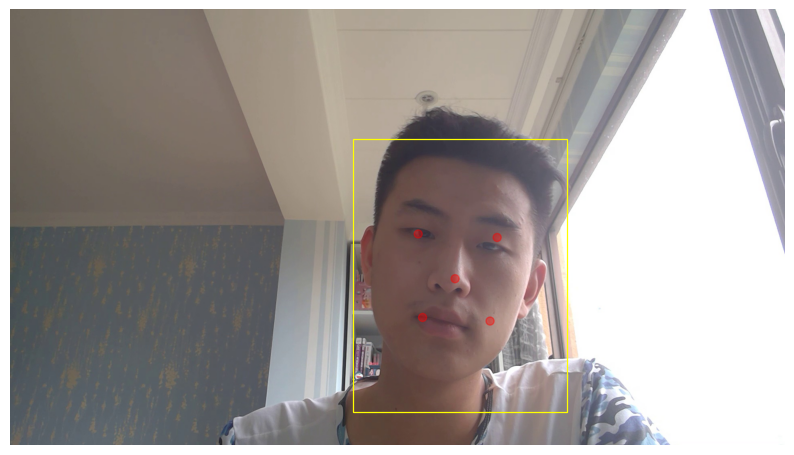

In [23]:
pic_path="output/chuhr1"
images_list = os.listdir(pic_path)
images_list.sort()
print(images_list.pop(0))
print(len(images_list))
image_name=images_list[99]
image_path=os.path.join(pic_path,image_name)
img = Image.open(image_path)
bboxs=np.array(json_data[99]["face_bbox"])
landmarks=np.array(json_data[99]["face_landmark"])
save_name="try1.jpg"
vis_face(img,bboxs,landmarks, save_name)    

## 测试我的model给出的信息

In [24]:
from torch.nn.modules.distance import PairwiseDistance

In [94]:
l2_distance = PairwiseDistance(2)

### embdedings 是一个list 里面的元素也是一个list（128个元素组成的list）
### 要判断那个框内的人是不是同一个人要取出那个特定的embedding

In [112]:
embeddings1=torch.Tensor(json_data[59]["face_embed"])
embeddings2=torch.Tensor(json_data[320]["face_embed"])

In [113]:
embedding1=embeddings1[0]
embedding2=embeddings2[0]

In [116]:
dist= l2_distance(embedding1,embedding2).item()

In [117]:
print(dist)

0.8228998780250549


In [90]:
print( best_distance_threshold)

2.1260780155658745


In [118]:
if dist<best_distance_threshold:
    print("same person")

same person
